In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

In [3]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

# Define the image preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


peacock.JPEG


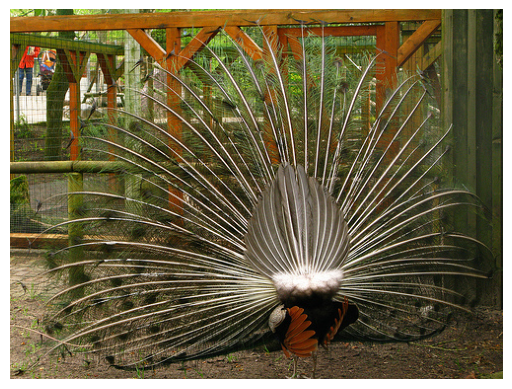

Predicted label: n01806143 (peacock)
piggy_bank.JPEG


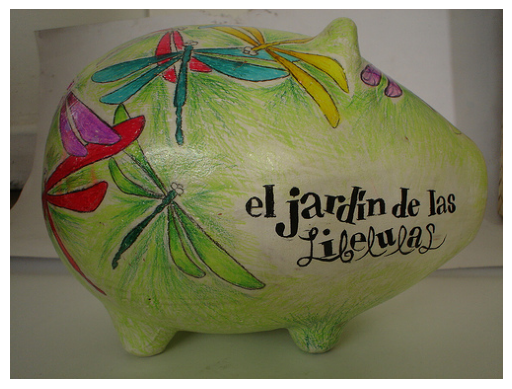

Predicted label: n03938244 (pillow)
mountain_bike.JPEG


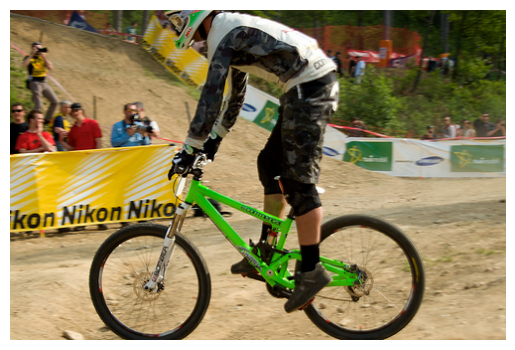

Predicted label: n03792782 (mountain_bike)
paintbrush.JPEG


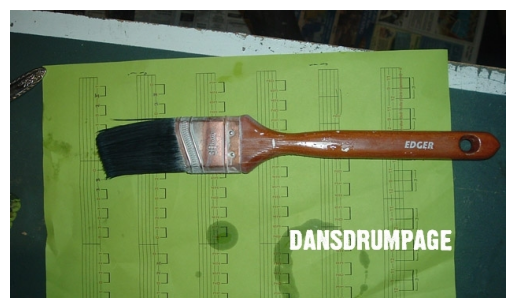

Predicted label: n04118776 (rule)
mousetrap.JPEG


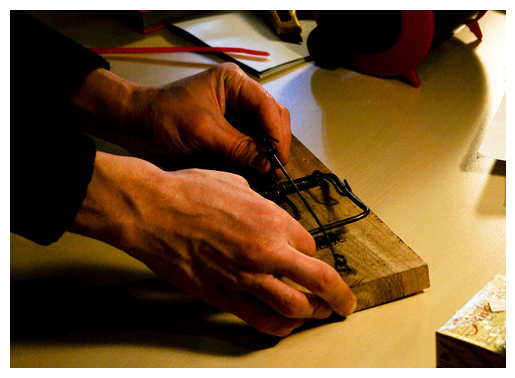

Predicted label: n03250847 (drumstick)


In [4]:
# Load the ImageNet class index mapping
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = 'imagenet_samples'

image_paths = os.listdir(imagenet_path)

for img_name in image_paths:
    print(img_name)
    img_path = os.path.join(imagenet_path, img_name)
    input_image = Image.open(img_path).convert('RGB')

    plt.imshow(input_image)
    plt.axis('off')
    plt.show()

    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]

    print(f"Predicted label: {predicted_synset} ({predicted_label})")

In [55]:
from skimage.segmentation import slic
from sklearn.linear_model import Lasso
from scipy.stats import kendalltau, spearmanr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [69]:
def generate_superpixels(image):
  superpixels = slic(image.astype(np.uint8), n_segments=50)
  return superpixels

In [74]:
def generate_perturbed_image(image, z_prime, superpixels, num_superpixels):
  perturbed_image = image.copy()
  for superpixel in range(1, num_superpixels + 1):
    if z_prime[superpixel - 1] == 0:
      perturbed_image[superpixels == superpixel] = np.mean(image)

  perturbed_image = Image.fromarray(perturbed_image.astype(np.uint8))
  perturbed_image = preprocess(perturbed_image).unsqueeze(0)

  if torch.cuda.is_available():
      perturbed_image = perturbed_image.to('cuda')

  return perturbed_image

In [79]:
def lime(image, superpixels, correct_class):
    image_np = np.array(image.resize((224, 224)))
    num_superpixels = superpixels.max()

    features = []
    targets = []
    pis = []

    for i in range(100):
      z_prime = np.random.randint(0, 2, num_superpixels)
      perturbed_image = generate_perturbed_image(image_np, z_prime, superpixels, num_superpixels)

      with torch.no_grad():
        output = model(perturbed_image)
        probs = F.softmax(output, dim=1)
        f_zi = probs[0, correct_class].item()

      pi_x = np.exp(-(np.sum(1 - z_prime) ** 2) / (5 ** 2))

      features.append(z_prime)
      targets.append(f_zi)
      pis.append(pi_x)

    reg = Lasso(alpha=0.04)
    reg.fit(features, targets, sample_weight=pis)
    weights = reg.coef_

    lime_explanation = np.zeros_like(superpixels, dtype=np.float32)

    superpixel_weights = np.abs(weights)
    superpixel_weights = superpixel_weights / (superpixel_weights.max() + 1e-8)

    for superpixel in range(1, num_superpixels + 1):
      lime_explanation[superpixels == superpixel] = superpixel_weights[superpixel - 1]

    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.imshow(lime_explanation, cmap="YlOrRd", alpha=0.5)
    plt.axis("off")
    plt.show()

    return weights


In [84]:
def smoothgrad(image, correct_class):
    image_np = np.array(image.resize((224, 224)))

    og_image = preprocess(image).unsqueeze(0)
    if torch.cuda.is_available():
        og_image = og_image.to('cuda')
    og_image.requires_grad = True

    gradients = torch.zeros_like(og_image)

    for _ in range(100):
      noise = np.random.normal(0, 0.2, size=og_image.shape)
      noise = torch.from_numpy(noise).to(dtype=og_image.dtype)
      perturbed_image = (og_image + noise).detach().requires_grad_()

      output = model(perturbed_image)
      prob = output[0, correct_class]
      model.zero_grad()
      prob.backward()
      gradients += perturbed_image.grad

    smoothed_gradients = (gradients / 100).abs()
    smoothed_gradients = smoothed_gradients.abs().mean(dim=1).cpu().numpy()[0]
    smoothed_gradients = smoothed_gradients / (smoothed_gradients.max() + 1e-8)

    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.imshow(smoothed_gradients, cmap="YlOrRd", alpha=0.8)
    plt.axis("off")
    plt.show()

    return smoothed_gradients


peacock.JPEG


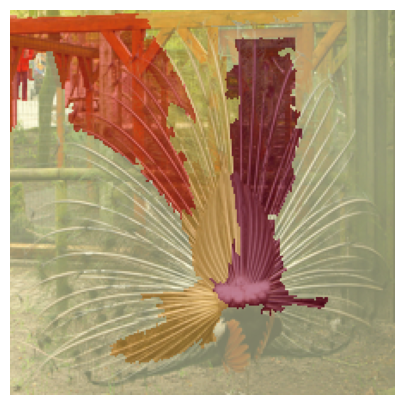

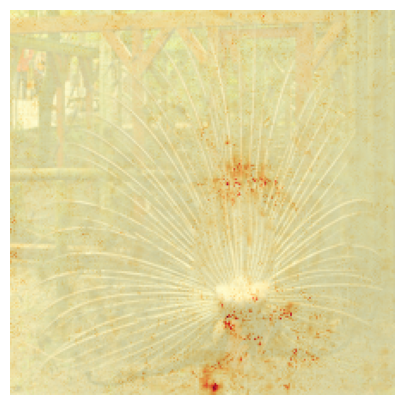

Kendall-Tau: 0.0901
Spearman: 0.0790
piggy_bank.JPEG


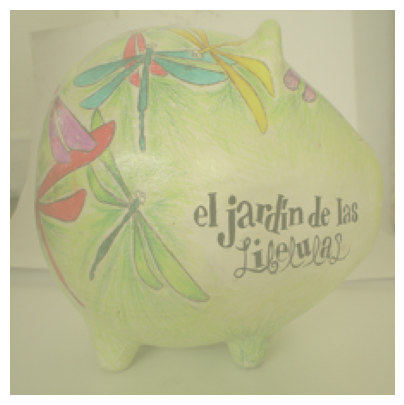

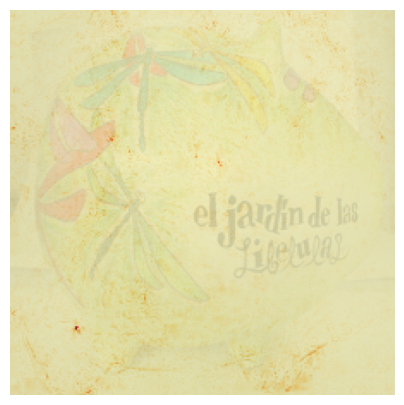

/tmp/ipython-input-3093369663.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, _ = spearmanr(lime_values, smoothgrad_values)


Kendall-Tau: nan
Spearman: nan
mountain_bike.JPEG


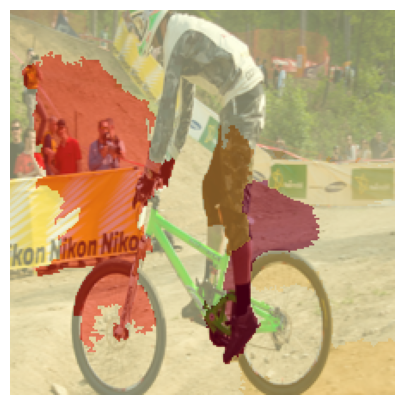

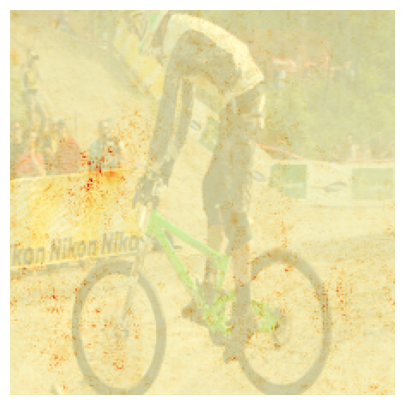

Kendall-Tau: 0.2267
Spearman: 0.3210
paintbrush.JPEG


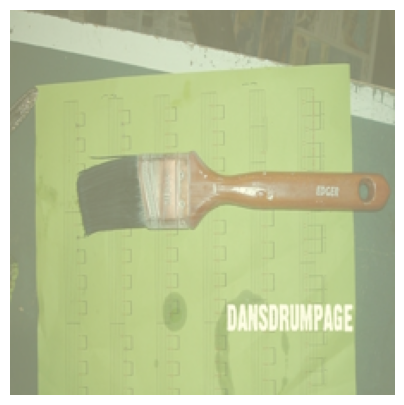

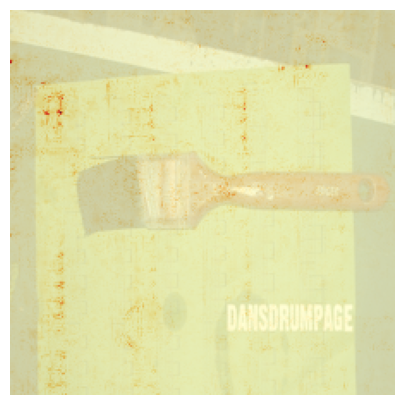

/tmp/ipython-input-3093369663.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, _ = spearmanr(lime_values, smoothgrad_values)


Kendall-Tau: nan
Spearman: nan
mousetrap.JPEG


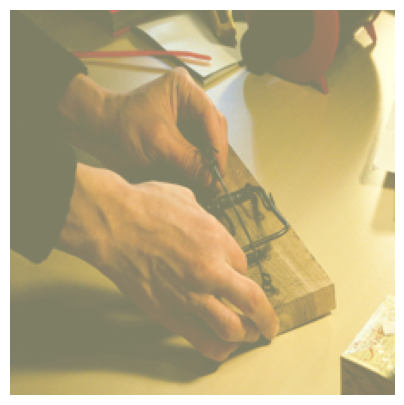

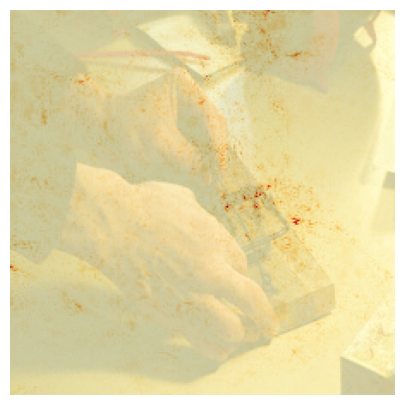

Kendall-Tau: nan
Spearman: nan


/tmp/ipython-input-3093369663.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman, _ = spearmanr(lime_values, smoothgrad_values)


In [85]:
from copy import deepcopy

imagenet_path = 'imagenet_samples'
image_paths = os.listdir(imagenet_path)

for img_name in image_paths:
    print(img_name)
    img_path = os.path.join(imagenet_path, img_name)

    input_image = Image.open(img_path).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    lime_img = deepcopy(input_image)
    smoothgrad_img = deepcopy(input_image)

    image_np = np.array(input_image.resize((224, 224)))
    superpixels = generate_superpixels(image_np)

    lime_values = lime(lime_img, superpixels, predicted_idx)
    smoothed_gradients = smoothgrad(smoothgrad_img, predicted_idx)

    num_superpixels = superpixels.max()
    smoothgrad_values = np.zeros(num_superpixels)
    for superpixel in range(1, num_superpixels + 1):
        smoothgrad_values[superpixel - 1] = smoothed_gradients[superpixels == superpixel].mean()

    kendall_tau, _ = kendalltau(lime_values, smoothgrad_values)
    spearman, _ = spearmanr(lime_values, smoothgrad_values)

    print(f"Kendall-Tau: {kendall_tau:.4f}")
    print(f"Spearman: {spearman:.4f}")